In [93]:
# Recreate figure analyses and plots - does not require caveCLIENT permissions

In [94]:
# import packages
import pandas as pd
from matplotlib import pyplot,patches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cmocean
import ptitprince as pt


In [311]:
# import dataframe
# multi_df = pd.read_pickle('pkls/preMN_to_MN_wing_v604.pkl') # preprint era materialization
# properties_df = pd.read_pickle('pkls/wingMN_properties_v604.pkl') # preprint era materialization

multi_df = pd.read_pickle('pkls/preMN_to_MN_wing_011524.pkl')
synapses_df = pd.read_pickle('pkls/synapse_positions_wing_011524.pkl')
properties_df = pd.read_pickle('pkls/mn_properties_wing_011524.pkl')


In [315]:
# figure 1 plots of size vs synapses

properties_df.head()

,pt_root_id,total_inputs,cell_type,total_volume_fixed_um,total_area_fixed_um
0,648518346492244419,11181,PS1,3710.471401,29440.501816
1,648518346493634040,9068,b2,5854.788514,25278.166660
2,648518346517546564,8796,DLM_5,9746.847218,38733.413808
3,648518346493247552,8408,i1,5788.456893,20759.696925
4,648518346482131604,7985,iii4a_u,3976.294801,20151.281253


0.9003400623551425


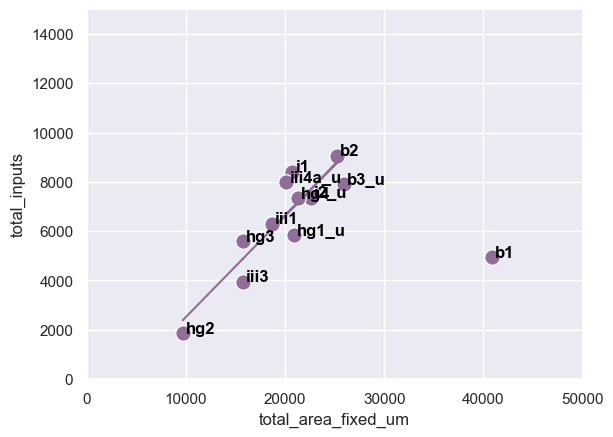

In [364]:
from scipy import stats

indirects_df = properties_df[properties_df.cell_type.str.startswith('D')].reset_index(drop=True)
tension_df = properties_df[properties_df.cell_type.str.startswith(('P','d','t'), na=False)].reset_index(drop=True)
direct_df = properties_df[properties_df.cell_type.str.startswith(('i','iii','hg','b'), na=False)].reset_index(drop=True)

source = direct_df
dx = source.total_area_fixed_um
dy = source.total_inputs

sns.scatterplot(data=source, x=dx, y=dy, s=124)
for point in range(0,source.shape[0]):
     plt.text(dx[point]+300, dy[point], source.cell_type[point], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')

source=source[~source.cell_type.isin(['b1'])]
dx = source.total_area_fixed_um
dy = source.total_inputs

slope, intercept, r, p, std_err = stats.linregress(dx, dy)
def myfunc(dx):
  return slope * dx + intercept
mymodel = list(map(myfunc, dx))
plt.plot(dx, mymodel)

plt.xlim(0,50000)
plt.ylim(0,15000)

# plt.savefig('../wing_xy_indir.svg', format='svg', bbox_inches='tight')
print(r)
plt.show()



In [6]:
# multi_df is already organized. Cosine similarity metrics are (re-)calculated below

In [99]:
anat_order = ['DLM_1', 'DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 'DVM_1a', 'DVM_1b', 'DVM_1c', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 'PS1', 'PS2', 'dtpmn_u', 'tp2', 'tpn', 'i1', 'i2_u', 'iii1', 'iii3', 'iii4a_u', 'hg1_u', 'hg2',  'hg3', 'hg4', 'b1', 'b2', 'b3_u']


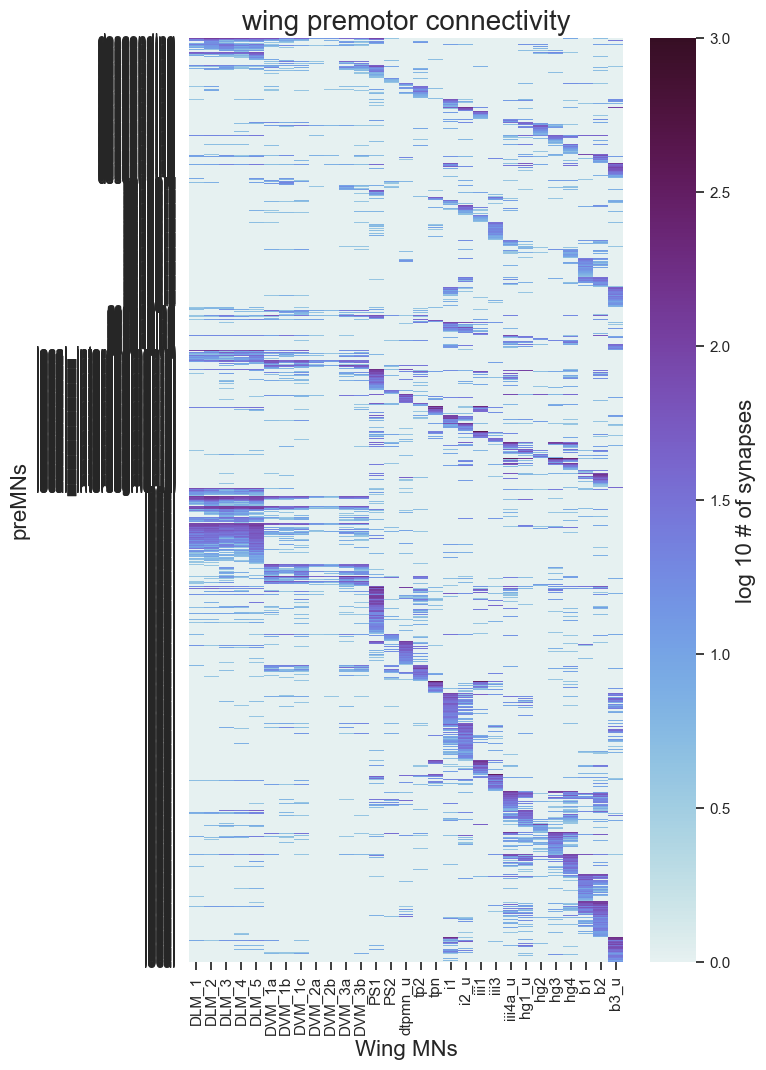

In [103]:
# plotting code for wing premotor connectome
source = multi_df[anat_order]

fig = plt.figure(1, figsize = [7,12])
sns.set(font_scale= 1)
cmap = cmocean.cm.dense

log_values = np.log10(source +1)
pmn_ids = source.index.get_level_values(level='classification_system').to_list()
mn_ids = source.columns.to_list()
ax = sns.heatmap(log_values, vmin = 0, vmax = 3, xticklabels=mn_ids, yticklabels=pmn_ids, cmap = cmap)

ax.xaxis.set_ticks_position('bottom')
cbar = ax.collections[0].colorbar
plt.title('wing premotor connectivity', size = 20)
cbar.set_label(label = 'log 10 # of synapses', size=16)
plt.xlabel('Wing MNs', size = 16)
plt.ylabel('preMNs', size = 16)
# plt.savefig('../wing_connmat011524.eps', format='eps', bbox_inches='tight')

plt.show()

In [102]:
source.index.get_level_values(level='classification_system').value_counts()

classification_system
local                   916
descending              271
local_intersegmental    265
sensory                 248
ascending                84
Name: count, dtype: int64

In [115]:
# plot proportions from each cell class
df_by_cell_class = multi_df.groupby(level='classification_system').sum().T.rename_axis('MN_label').reset_index()

dict_syn = dict(zip(properties_df.MN_label, properties_df.total_inputs))

df_by_cell_class['synapses_with_fragments'] = df_by_cell_class.MN_label.map(dict_syn)

# dataframe of proportions for plotting
df_by_cell_class_proportions = df_by_cell_class[['local','local_intersegmental','ascending','sensory','descending']].divide(df_by_cell_class.synapses_with_fragments, axis=0)


/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_47888/4110739214.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_by_cell_class = multi_df.groupby(level='classification_system').sum().T.rename_axis('MN_label').reset_index()


In [116]:
df_by_cell_class_proportions.index = df_by_cell_class['MN_label']
df_by_cell_class_proportions['fragment'] = df_by_cell_class_proportions.apply(
    lambda x: 1 - (x['ascending'] + x['descending'] + x['sensory'] + x['local_intersegmental'] + x['local']), axis=1)


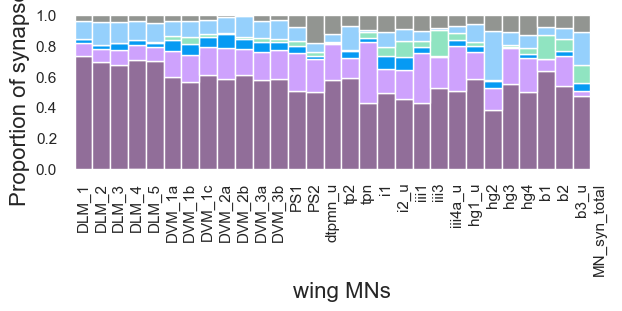

In [117]:
source = df_by_cell_class_proportions

colors_cell_class = ["#916e99","#cea2fd","#069af3","#90e4c1","#95d0fc","#929591", "#650021"]
cmap_cell_class = sns.set_palette(sns.color_palette(colors_cell_class))

#create stacked bar chart
p = source.plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap_cell_class, figsize=(7, 2)) 

p.set_ylabel("Proportion of synapses",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("wing MNs", fontsize = 16)
plt.box(on = False)
plt.savefig('../wing_classproportions011524.svg', format='svg', bbox_inches='tight')

plt.show()

In [126]:
df_by_cell_class = df_by_cell_class[:-1]

In [133]:
# for all wing MNs combined
df_by_cell_class['fragment'] = df_by_cell_class.apply(
    lambda x: x['synapses_with_fragments'] - (x['ascending'] + x['descending'] + x['sensory'] + x['local_intersegmental'] + x['local']), axis=1)

df_total = df_by_cell_class[['local','local_intersegmental','ascending','sensory','descending','fragment']].sum().divide(df_by_cell_class.synapses_with_fragments.sum(), axis=0) # right order


/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_47888/3059341934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_cell_class['fragment'] = df_by_cell_class.apply(


In [134]:
df_total

classification_system
local                   0.562483
local_intersegmental    0.176890
ascending               0.041332
sensory                 0.042654
descending              0.100246
fragment                0.076395
dtype: float64

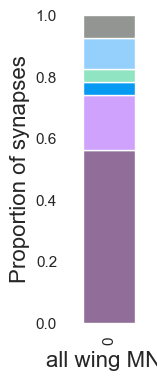

In [135]:
# plot for all wing MNs combined
source = pd.DataFrame(df_total).T

#create stacked bar chart
p = source.plot(kind='bar', stacked=True, width = 1, legend = False, cmap = cmap_cell_class, figsize=(1, 4)) 

p.set_ylabel("Proportion of synapses",fontsize = 16)
p.set(ylim=(0, 1))
p.set_xlabel("all wing MNs", fontsize = 16)
plt.box(on = False)
plt.savefig('../wingALLmn_classproportions011524.svg', format='svg', bbox_inches='tight')

plt.show()

In [136]:
# cosine similarity of MNs based on preMN input

In [137]:
def plot_dendrogram(model, **kwargs):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    
    return clustered_order


In [138]:
def organize_by_cos_short(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy().transpose())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[:,clustered_order]
    sim_mat = cosine_similarity(reordered_df.to_numpy().transpose())
    
    return clustered_order

In [139]:
def organize_by_cos_long(map_df):
    adj = pd.crosstab(map_df['pre_pt_root_id'],map_df['post_pt_root_id'])
    sim_mat_temp = cosine_similarity(adj.to_numpy())
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_temp)
    clustered_order = plot_dendrogram(model)#, truncate_mode="level", p=12) # p truncate mode
    clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    reordered_df = adj.iloc[clustered_order,:]
    sim_mat = cosine_similarity(reordered_df.to_numpy())
    
    
    return reordered_df

In [140]:
syn_df = synapses_df
syn_df.head()

,pre_pt_root_id,post_pt_root_id,pre_pt_position,post_pt_position
1,648518346481006938,648518346493247552,"[23027, 124385, 1028]","[23007, 124409, 1029]"
2,648518346481006938,648518346493247552,"[23045, 124407, 1025]","[23029, 124447, 1025]"
3,648518346481006938,648518346471876251,"[23069, 124559, 993]","[23029, 124571, 994]"
4,648518346481006938,648518346471876251,"[23027, 124591, 967]","[23043, 124563, 969]"
10,648518346467079918,648518346494250631,"[33603, 124167, 950]","[33585, 124181, 949]"


In [141]:
syn_df.pre_pt_root_id.value_counts()

pre_pt_root_id
648518346491506374    1609
648518346487847703    1130
648518346481490789    1086
648518346479342290     917
648518346486676988     912
                      ... 
648518346466923758       3
648518346479917044       3
648518346475448704       3
648518346496072716       3
648518346496396924       3
Name: count, Length: 1784, dtype: int64

In [142]:
pmns = multi_df.index.get_level_values(level='pre_pt_root_id').to_list()


In [143]:
set(pmns) - set(syn_df.pre_pt_root_id.to_list())

set()

In [144]:
multi_df.index.get_level_values(level='pre_pt_root_id').value_counts() # should all be one

pre_pt_root_id
648518346470309374    1
648518346507298632    1
648518346502313043    1
648518346484500995    1
648518346497999770    1
                     ..
648518346501350029    1
648518346475412065    1
648518346517952104    1
648518346485643283    1
648518346487808023    1
Name: count, Length: 1784, dtype: int64

In [145]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

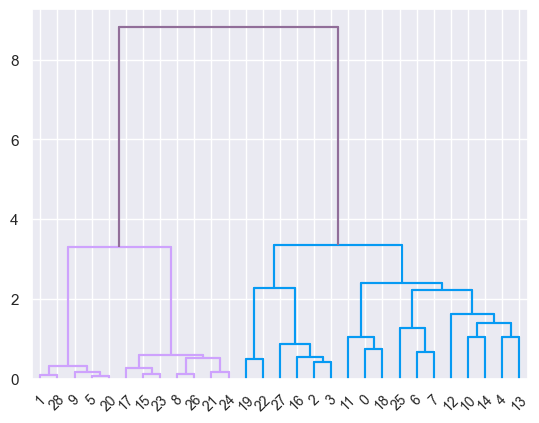

In [146]:
adj = pd.crosstab(syn_df.pre_pt_root_id,syn_df.post_pt_root_id)
clustered_order = organize_by_cos_short(syn_df)
adj_ordered = adj.iloc[:,clustered_order]

In [147]:
clust_order = ['DLM_1', 'DLM_2', 'DLM_3', 'DLM_4', 'DLM_5', 
               'DVM_1a', 'DVM_1b', 'DVM_1c', 'DVM_2a', 'DVM_2b', 'DVM_3a', 'DVM_3b', 
                'PS1',
                'dtpmn_u','PS2', 'tp2',
                'iii3','tpn', 'iii1',  
                'i2_u','i1','b3_u',
                'b1', 'b2',
                'hg1_u','hg3', 'hg4','iii4a_u', 
                'hg2']


In [151]:
dict_mn = dict(zip(properties_df.pt_root_id, properties_df.MN_label))
adj_ordered.rename(columns=dict_mn, inplace=True)

## toggle for anatomical ordering vs module clustering
adj_ordered = adj_ordered[anat_order]
# adj_ordered = adj_ordered[clust_order]

mn_ids = adj_ordered.columns

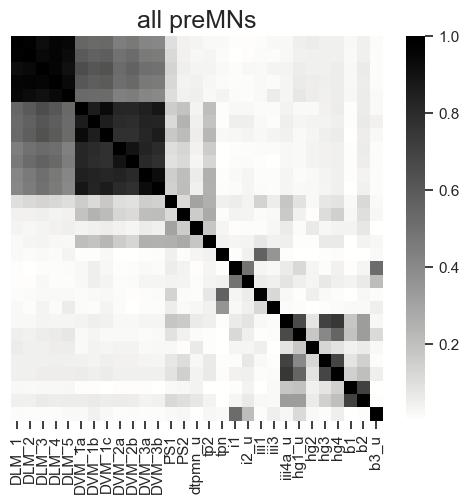

In [152]:
sim_mat = cosine_similarity(adj_ordered.to_numpy().transpose())

fig = plt.figure(1, figsize = [6,5])
cmap = cmocean.cm.gray_r
ax = sns.heatmap(sim_mat, xticklabels = mn_ids, yticklabels = '', cmap = cmap)# xticklabels=mn_ids, cmap = cmap)
cbar = ax.collections[0].colorbar
ax.xaxis.set_ticks_position('bottom')

plt.xlabel('', fontsize =16)
plt.title('all preMNs', fontsize = 18)
# plt.savefig('wing_clustsim1115.svg', format='svg', bbox_inches='tight')

plt.show()

In [31]:
# plot distributions of module preference according to cell class 
# need to create a dataframe where each row contains a unique preMN ID, its cell class, and the fraction of its output onto a single motor cluster, and total # of MN synapses

In [153]:
# motor clusters
cluster_dict = {
"DLM_clu" : ['DLM_1','DLM_2','DLM_3','DLM_4','DLM_5'],
"DVM_clu" : ['DVM_1a','DVM_1b','DVM_1c','DVM_2a','DVM_2b','DVM_3a','DVM_3b'],
"tension_clu" : ['PS1','PS2','dtpmn_u','tp2'],
"steerA_clu" : ['tpn','iii1','iii3'],
"steerB_clu" : ['i2_u','i1','b3_u'],
"steerC_clu" : ['b2','b1'],
"hg2_clu" : ['hg2'],
"steerD_clu" : ['hg1_u','hg3','hg4','iii4a_u']
}
flat_dict = {val:key for key, lst in cluster_dict.items() for val in lst}

In [154]:
properties_df['cluster'] = properties_df.MN_label.map(flat_dict)
properties_df = properties_df.rename(columns={'MN_id':'post_pt_root_id'})

In [161]:
syn_df = syn_df.merge(properties_df.rename(columns={'pt_root_id':'post_pt_root_id'})[['post_pt_root_id','cluster']])

In [162]:
adj = pd.crosstab(syn_df.pre_pt_root_id,syn_df.cluster)
adj.head()

cluster,DLM_clu,DVM_clu,hg2_clu,steerA_clu,steerB_clu,steerC_clu,steerD_clu,tension_clu
pre_pt_root_id,,,,,,,,
648518346459413252,0,0,0,1,0,38,0,0
648518346459520004,138,72,0,0,0,0,0,53
648518346459550468,49,0,0,0,0,2,3,0
648518346459573508,0,1,0,5,84,0,1,2
648518346459589380,1,0,0,0,27,0,1,0


In [164]:
pref_df = pd.DataFrame(adj.sum(axis=1).reset_index(name='MN_syn'))
pref_df = pref_df.merge(pd.DataFrame(adj.max(axis=1).reset_index(name='top_syn')))
pref_df['proportion'] = pref_df.top_syn / pref_df.MN_syn
pref_df = pref_df.merge(multi_df.reset_index()[['pre_pt_root_id','classification_system']])

pref_df['log_syn'] = np.log(pref_df['MN_syn'])
pref_df['syn_bin'] = pd.cut(pref_df.log_syn,10) # bin number of MN synapses for plotting by hue

pref_df.head()

,pre_pt_root_id,MN_syn,top_syn,proportion,classification_system,log_syn,syn_bin
0,648518346459413252,39,38,0.974359,local,3.663562,"(3.613, 4.241]"
1,648518346459520004,263,138,0.524715,descending,5.572154,"(5.498, 6.126]"
2,648518346459550468,54,49,0.907407,local,3.988984,"(3.613, 4.241]"
3,648518346459573508,93,84,0.903226,local,4.532599,"(4.241, 4.869]"
4,648518346459589380,29,27,0.931034,local,3.367296,"(2.984, 3.613]"


/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/

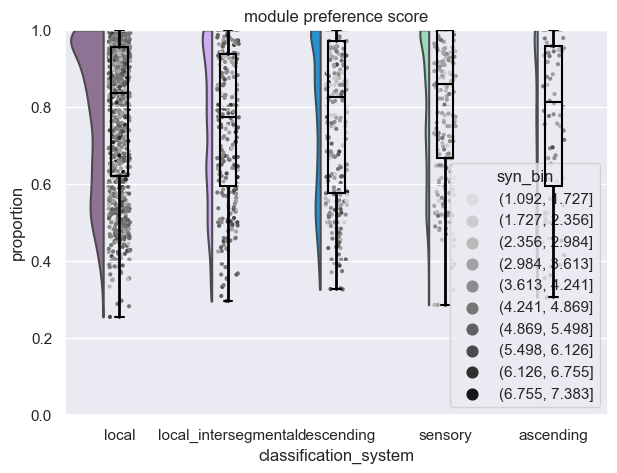

In [166]:
ort = 'v' # vertical or horizontally oriented plot
dx = "classification_system"
dy = "proportion"
class_order = ['local', 'local_intersegmental','descending','sensory','ascending']
plot_df = pref_df

pal = sns.color_palette("Greys", n_colors=12)
pal = pal[2:]

f, ax = plt.subplots(figsize=(7, 5))

ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, bw = .2, cut = 0.,
scale = "count", width = .6, inner = None, orient = ort, order=class_order)

ax=sns.stripplot( x = dx, y = dy, data = plot_df, hue="syn_bin", palette = pal,
size = 3, jitter = 1, zorder = 0, orient = ort, order=class_order) # edgecolor = "white"

ax=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort, order=class_order)
plt.ylim(0,1)
plt.title("module preference score")
plt.show()

In [ ]:
# similarity plots, as in Figure 3F
# create a dataframe where the rows are pairs of within-module MNs and each column is the cosine similarity when preMNs are broken up by cell class 

In [172]:
# create a labeled version of syn_df, with a column for the MN label of postIDs and preMN class for preIDs
labeled_syn_df = syn_df.merge(properties_df.rename(columns={'pt_root_id':'post_pt_root_id'})[['post_pt_root_id', 'MN_label','cluster']],how='left')
labeled_syn_df = labeled_syn_df.merge(multi_df.reset_index()[['pre_pt_root_id','classification_system']],how='left')
labeled_syn_df.head()

,pre_pt_root_id,post_pt_root_id,pre_pt_position,post_pt_position,cluster,MN_label,classification_system
0,648518346481006938,648518346493247552,"[23027, 124385, 1028]","[23007, 124409, 1029]",steerB_clu,i1,local
1,648518346481006938,648518346493247552,"[23045, 124407, 1025]","[23029, 124447, 1025]",steerB_clu,i1,local
2,648518346501447768,648518346493247552,"[29677, 132349, 1200]","[29707, 132333, 1200]",steerB_clu,i1,descending
3,648518346520517686,648518346493247552,"[29781, 132355, 1199]","[29791, 132353, 1201]",steerB_clu,i1,local
4,648518346486034558,648518346493247552,"[29861, 132657, 1164]","[29827, 132667, 1166]",steerB_clu,i1,ascending


In [173]:
# quantify similarity for within-module pairwise comparisons

In [271]:
# cos-sim function: input = adjacency matrix with MNs as columns, output = long dataframe with one column of similarity value, and one column for each MN being compared

def adj_to_long_sim (adj_df):
    cs_df = cosine_similarity(adj_df.to_numpy().transpose())
    column_names = adj_df.columns
    df = pd.DataFrame(cs_df, columns=column_names)
    df['mn_1'] = column_names
    df = df.set_index("mn_1")
    df_long = pd.melt(df.reset_index(), id_vars='mn_1', value_vars=adj_df.columns).rename(columns={'post_pt_root_id':'mn_2'})

    # get rid of duplicates and self-comparisons
    df_long = df_long[df_long['mn_1'] != df_long['mn_2']].reset_index(drop=True)
    mns_combined = []
    i=0
    while i < len(df_long):
        if df_long.mn_1[i] > df_long.mn_2[i]:
            # df_long.mns_combined[i] = str(df_long.mn_1[i]) + 'X' + str(df_long.mn_2[i])
            mns_combined.append(str(df_long.mn_1[i]) + 'X' + str(df_long.mn_2[i]))
        else:
            # df_long.mns_combined[i] = str(df_long.mn_2[i]) + 'X' + str(df_long.mn_1[i])
            mns_combined.append(str(df_long.mn_2[i]) + 'X' + str(df_long.mn_1[i]))

        i=i+1
        
    df_long['mns_combined'] = pd.Series(mns_combined)
    df_long = df_long.drop_duplicates(subset='mns_combined').reset_index(drop=True)

    return df_long



In [313]:
# all
df_long_all = adj_to_long_sim(adj_ordered)
df_long_all['cell_class'] = 'all'

# local
df_long_local = adj_to_long_sim(adj_ordered[adj_ordered.index.isin(
    multi_df[multi_df.index.get_level_values(level='classification_system').isin(
        ['local'])].index.get_level_values(level='pre_pt_root_id').to_list())])
df_long_local['cell_class'] = 'local'

# local_intersegmental
df_long_intersegmental = adj_to_long_sim(adj_ordered[adj_ordered.index.isin(
    multi_df[multi_df.index.get_level_values(level='classification_system').isin(
        ['local_intersegmental'])].index.get_level_values(level='pre_pt_root_id').to_list())])
df_long_intersegmental['cell_class'] = 'local_intersegmental'

# ascending
df_long_ascending = adj_to_long_sim(adj_ordered[adj_ordered.index.isin(
    multi_df[multi_df.index.get_level_values(level='classification_system').isin(
        ['ascending'])].index.get_level_values(level='pre_pt_root_id').to_list())])
df_long_ascending['cell_class'] = 'ascending'

# sensory
df_long_sensory = adj_to_long_sim(adj_ordered[adj_ordered.index.isin(
    multi_df[multi_df.index.get_level_values(level='classification_system').isin(
        ['sensory'])].index.get_level_values(level='pre_pt_root_id').to_list())])
df_long_sensory['cell_class'] = 'sensory'

# descending
df_long_descending = adj_to_long_sim(adj_ordered[adj_ordered.index.isin(
    multi_df[multi_df.index.get_level_values(level='classification_system').isin(
        ['descending'])].index.get_level_values(level='pre_pt_root_id').to_list())])
df_long_descending['cell_class'] = 'descending'

In [288]:
df_long = pd.concat([df_long_all,df_long_local,df_long_intersegmental,df_long_ascending,df_long_sensory,df_long_descending])

In [289]:
len(df_long) # should be 2436

2436

In [296]:
# add a column to indicate within or across module comparisons

df_long = df_long.merge(properties_df.rename(columns={'MN_label':'mn_1','cluster':'module_1'})[['mn_1','module_1']])
df_long = df_long.merge(properties_df.rename(columns={'MN_label':'mn_2','cluster':'module_2'})[['mn_2','module_2']])

df_long.loc[df_long['module_1'] == df_long['module_2'], 'match'] = 'within'
df_long.loc[df_long['module_1'] != df_long['module_2'], 'match'] = 'across'

/var/folders/kc/3ksx1s8x04xcd7r2v8zsqqtm0000gn/T/ipykernel_47888/1459879352.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'within' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_long.loc[df_long['module_1'] == df_long['module_2'], 'match'] = 'within'


/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/ellenlesser/Desktop/code/Lesser_Azevedo_2023/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: Fut

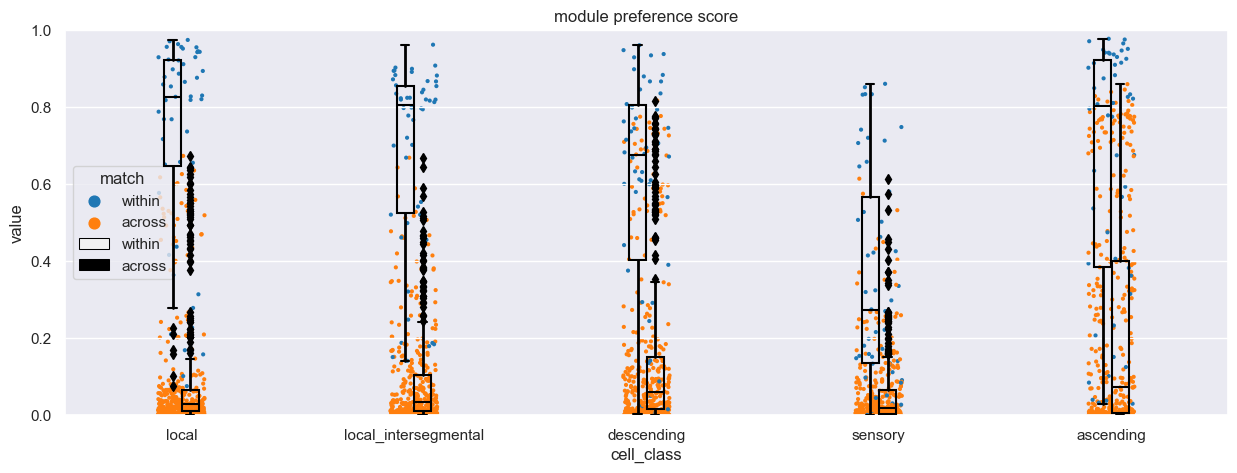

In [309]:
ort = 'v' # vertical or horizontally oriented plot
dx = "cell_class"
dy = "value"
hu = "match"
class_order = ['local', 'local_intersegmental','descending','sensory','ascending']
plot_df = df_long

pal = sns.color_palette("tab10")

f, ax = plt.subplots(figsize=(15, 5))

ax=sns.stripplot( x = dx, y = dy, data = plot_df, hue=hu, palette = pal,
size = 3, jitter = 1, zorder = 0, orient = ort, order=class_order)

ax=sns.boxplot( x = dx, y = dy, hue=hu, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort, order=class_order)

plt.ylim(0,1)
plt.title("module preference score")
plt.show()